In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from importlib import reload

import KernelTools
reload(KernelTools)
from KernelTools import vectorize_kfunc,dxx_k,diff2_k

from Kernels import setup_matern

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm

from jax.scipy.linalg import solve


import sympy as sym
from sympy import factorial
from sympy.series.series import series


In [2]:
import jax.version


jax.version._release_version

'0.4.38'

In [3]:
jax.grad(jnp.linalg.norm)(0.)

Array(nan, dtype=float64, weak_type=True)

In [4]:
from jax import custom_jvp
from jax import lax

@custom_jvp
def two_norm(x):
  return jnp.sqrt(jnp.sum(x**2))

@two_norm.defjvp
def two_norm_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = two_norm(x)
  ans_dot = jnp.dot(x,x_dot)/(two_norm(x)+1e-32)
  return ans, ans_dot
  # return ans, jnp.where(ans!=0,ans_dot,0.)


In [5]:
def build_matern(p,rho):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)

    def matern_func(x,y):
        scaled_diff = (x-y)/rho
        d = two_norm(scaled_diff)
        matern_eval= jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
        return matern_eval#jnp.where(d2<eps, asymptotic, true)
        
    return matern_func



nan


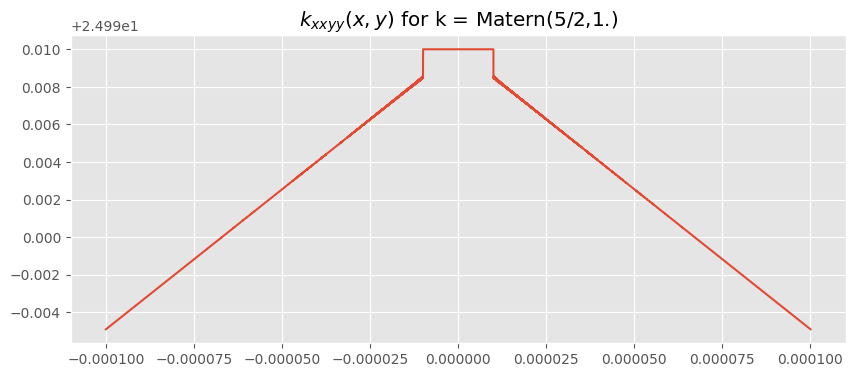

In [6]:
def setup_matern(p,eps = 1e-5):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)
    # S = series(sym.log(matern),d,0,2*p+1).removeO()
    S = series(matern,d,0,2*p+1).removeO()
    polyS = sym.Poly(S,d)
    asy_coeffs = polyS.coeffs()
    asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

    asy_powers = polyS.monoms()
    half_asy_powers = jnp.array(asy_powers)[:,0]//2

    def matern_p_factory(rho):
        def matern_func(x,y):
            d2 = jnp.sum((x-y)**2)/(rho**2) + 1e-50# + 1e-36
            # d = jnp.sqrt(d2)
            d = jnp.linalg.norm((x-y)/rho)
            true = jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
            # asymptotic = jnp.exp(jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers)))
            asymptotic = jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers))
            return jnp.where(d<eps, asymptotic, true)
        return matern_func
    return matern_p_factory


k = setup_matern(2,eps = 1e-5)(1.)
extent = 1e-4
grid = jnp.linspace(-extent,extent,50000)
print(diff2_k(diff2_k(k,0),1)(0.,0.))
result = jax.vmap(diff2_k(diff2_k(k,0),1),in_axes = (None,0))(0.,grid)

plt.figure(figsize=(10,4))
plt.plot(grid,result)
plt.title("$k_{xxyy}(x,y)$ for k = Matern(5/2,1.)")
plt.show()

nan


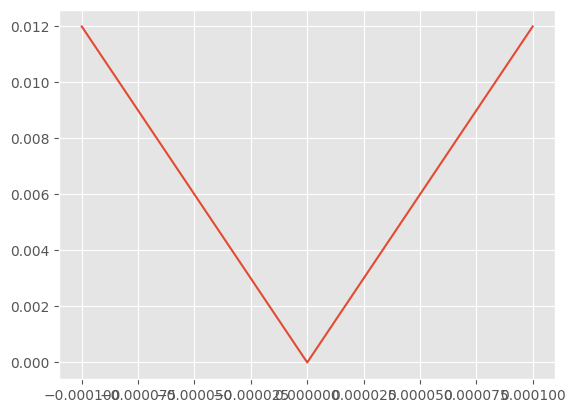

In [8]:
def f(x):
    return (x**4) * jnp.linalg.norm(x)

g = jax.grad(jax.grad(jax.grad(jax.grad(f))))
print(g(0.))
plt.plot(grid,jax.vmap(g)(grid))

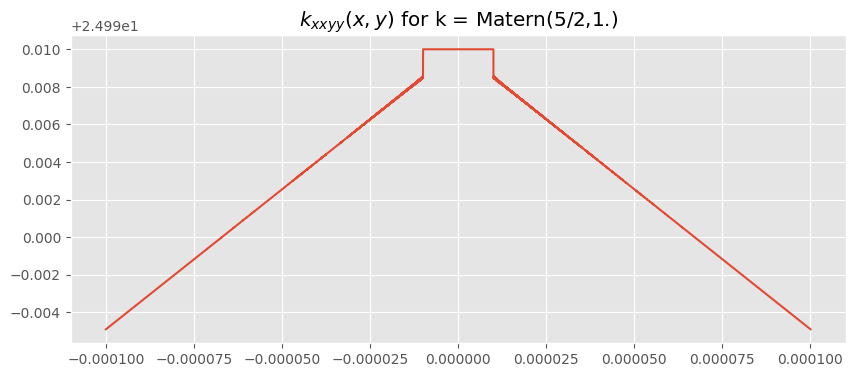

In [10]:
plt.figure(figsize=(10,4))
plt.plot(grid,result)
plt.title("$k_{xxyy}(x,y)$ for k = Matern(5/2,1.)")
plt.show()

In [11]:
import jax
import sympy
import sympy2jax

x_sym = sympy.symbols("x_sym")
cosx = 1.0 * sympy.cos(x_sym)
sinx = 2.0 * sympy.sin(x_sym)
mod = sympy2jax.SymbolicModule([cosx, sinx])  # PyTree of input expressions

x = jax.numpy.zeros(3)
out = mod(x_sym=x)  # PyTree of results.
params = jax.tree.leaves(mod)  # 1.0 and 2.0 are parameters.


In [12]:
p = 2
eps = 1e-8

exp_multiplier = -sym.sqrt(2 * p + 1)
coefficients = [
    (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
    * (sym.sqrt(8 * p + 4))**(p - i) 
    for i in range(p + 1)]
powers = list(range(p,-1,-1))

jax_coefficients = jnp.array(list(map(float,coefficients)))
jax_powers = jnp.array(powers)
jax_exp_multiplier = float(exp_multiplier)

d = sym.symbols('d')
matern = sum([coefficients[0]] + [c * (d**power) for c,power in zip(coefficients[1:],powers[1:])])*sym.exp(exp_multiplier * d)
S = series(sym.log(matern),d,0,2*p+1).removeO()
# S = series(matern,d,0,2*p+1).removeO()#Try an extra order ad hoc?
polyS = sym.Poly(S,d)
asy_coeffs = polyS.coeffs()
asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

asy_powers = polyS.monoms()
half_asy_powers = jnp.array(asy_powers)[:,0]//2


Array([1.66666667, 1.66666667, 1.66666667], dtype=float64, weak_type=True)

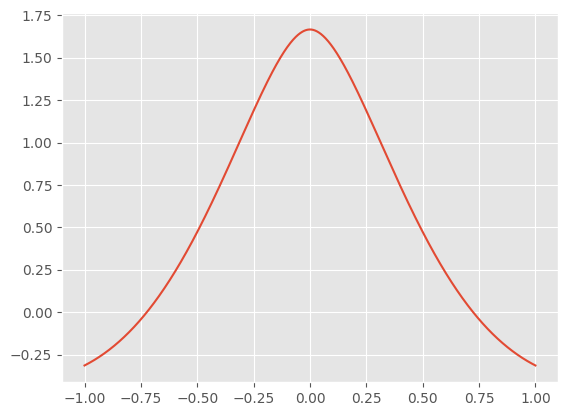

In [179]:
d2 = sym.symbols('d2',positive=True)
p = 2
eps = 1e-8

exp_multiplier = -sym.sqrt(2 * p + 1)
coefficients = [
    (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
    * (sym.sqrt(8 * p + 4))**(p - i) 
    for i in range(p + 1)]
powers = list(range(p,-1,-1))


matern = (
    sum([
        c * sym.sqrt((d2**power)) for c,power in zip(coefficients,powers)
        ]
    )
        *sym.exp(exp_multiplier * sym.sqrt(d2))
)

matern_func_raw = sympy2jax.SymbolicModule(matern)
matern_func = lambda d2:matern_func_raw(d2 = d2)



diff = sym.simplify(sym.Derivative(matern,d2,evaluate = True))
diff_mod = sympy2jax.SymbolicModule(diff)
jax_matern_diff = custom_jvp(lambda d2:diff_mod(d2 = d2))

diff2 = sym.simplify(sym.Derivative(matern,(d2,2),evaluate = True))
diff2_mod = sympy2jax.SymbolicModule(diff2)
jax_matern_diff2 = lambda d2:diff2_mod(d2 = d2)

@custom_jvp
def maternbase(d2):
   return matern_func(d2)

@maternbase.defjvp
def maternjvp(primals,tangents):
  x, = primals
  x_dot, = tangents
  ans = maternbase(x)
  ans_dot = jax_matern_diff(x)*x_dot
  return ans,ans_dot

@jax_matern_diff.defjvp
def materndiffjvp(primals,tangents):
  x, = primals
  x_dot, = tangents
  ans = jax_matern_diff(x)
  ans_dot = jax_matern_diff2(x)*x_dot
  return ans,ans_dot


def k(x,y):
    d2 = jnp.sum((x-y)**2)
    return maternbase(d2)


kvec = jax.vmap(k,in_axes = (None,0))
kvgg = jax.vmap(jax.grad(jax.grad(k,1),0),in_axes=(None,0))
extent = 1.
grid = jnp.linspace(-extent,extent,1000)
plt.plot(grid,kvgg(0.,grid))

kvgg(0.,jnp.zeros(3))

In [175]:
jax_matern_diff(0.)

Array(-0.59090909, dtype=float64, weak_type=True)

In [ ]:
mod = sympy2jax.SymbolicModule(diff)


5*(-3*sqrt(d2) - sqrt(5))*exp(-sqrt(5)*sqrt(d2))/(6*sqrt(d2))

In [115]:
diff = sym.Derivative(matern,(d,5),evaluate = True)
diff

25*sqrt(5)*(-sqrt(5)*d + 7/3)*exp(-sqrt(5)*d)

In [16]:
from jax import custom_jvp
from jax import lax

def test(x):
  return 3 * x

test = custom_jvp(test)

@test.defjvp
def testjvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = test(x)
  ans_dot = 10*jnp.ones_like(x)
  return ans, 3.



In [17]:
jax.grad(test)(10.)

Array(0., dtype=float64, weak_type=True)

In [104]:
# @custom_jvp
def test(x):
  return x**2

test = custom_jvp(test)

@test.defjvp
@custom_jvp
def test_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = test(x)
  ans_dot = 1000*ans*x_dot
  return ans, ans_dot

@test_jvp.defjvp
def test_jvp2(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = test_jvp(x)
  ans_dot = 1000*x_dot
  return ans, ans_dot


In [105]:
jax.grad(jax.grad(test))(1.)

Array(1000000., dtype=float64, weak_type=True)

In [95]:
jax.make_jaxpr(jax.grad(jax.grad(test)))(3.)

{ lambda ; a:f64[]. let
    b:f64[] = custom_jvp_call[
      call_jaxpr={ lambda ; c:f64[]. let d:f64[] = integer_pow[y=2] c in (d,) }
      jvp_jaxpr_thunk=<function _memoize.<locals>.memoized at 0x7fcd482134c0>
      num_consts=0
      symbolic_zeros=False
    ] a
    e:f64[] = mul 5.0 b
    f:f64[] = mul 5.0 b
    _:f64[] = mul f 1.0
    g:f64[] = mul 1.0 1.0
    h:f64[] = mul 5.0 g
    i:f64[] = mul e h
  in (i,) }

In [86]:
primals,vjp = jax.vjp(test,3.)
vjp(1.)

(Array(45., dtype=float64, weak_type=True),)

TypeError: custom_vjp.defvjp() missing 1 required positional argument: 'bwd'